In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import datetime as dt
import math
import datetime
from datetime import timedelta
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
#from common.utils import load_data, mape
from IPython.display import Image
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [2]:
os.chdir('C:\\Users\\omkarp\\Desktop\\KTH files\\python\\')
df = pd.read_excel('03_Graffiti.xlsx')
df.head()

,Kategori,Date,SynpunktCommonWord,DpFeatureType,Koordinater_X,Koordinater_Y,count,factor
0,Felanmälan,2019-01-01,Klotter,Klotter,"156,001.31","6,577,125.14",1,1
1,Felanmälan,2019-01-01,Klotter,Klotter,"156,111.44","6,577,348.71",1,1
2,Felanmälan,2019-01-01,Klotter,Klotter,"148,711.61","6,576,788.69",1,1
3,Felanmälan,2019-01-01,Klotter,Klotter,"148,711.61","6,576,788.69",1,1
4,Felanmälan,2019-01-01,Klotter,Klotter,"155,959.52","6,577,598.68",1,1


In [3]:
df = df.groupby(["Date","SynpunktCommonWord", "DpFeatureType","Koordinater_X","Koordinater_Y"]).size().reset_index(name="count")
df = df.drop(columns = ["SynpunktCommonWord", "DpFeatureType","Koordinater_X", "Koordinater_Y"])
df.sort_values(by=['Date'], ignore_index= True)
df = df.groupby(["Date"]).size().reset_index(name="count")
df = df.reset_index(drop=True).dropna()
df.rename(columns={'count':'Incidents'}, inplace=True)
df.head()

,Date,Incidents
0,2019-01-01,18
1,2019-01-02,20
2,2019-01-03,28
3,2019-01-04,27
4,2019-01-05,34


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       883 non-null    datetime64[ns]
 1   Incidents  883 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 KB


In [5]:
df=df.set_index('Date')
df.head()

,Incidents
Date,
2019-01-01,18
2019-01-02,20
2019-01-03,28
2019-01-04,27
2019-01-05,34


In [6]:
from datetime import date, timedelta
sdate = date(2019,1,1)   # start date
edate = date(2021,6,5)   # end date #date(2021,6,5)

pd.date_range(sdate,edate-timedelta(days=1),freq='d')
s=[sdate+timedelta(days=x) for x in range((edate-sdate).days)]
df3 = pd.DataFrame(s) 
df3=df3.rename(columns={0:'Date'})
df3=df3.set_index('Date')
df3['Incidents'] = df['Incidents']
df3=df3.fillna(0)
df3.head()

,Incidents
Date,
2019-01-01,18.00
2019-01-02,20.00
2019-01-03,28.00
2019-01-04,27.00
2019-01-05,34.00


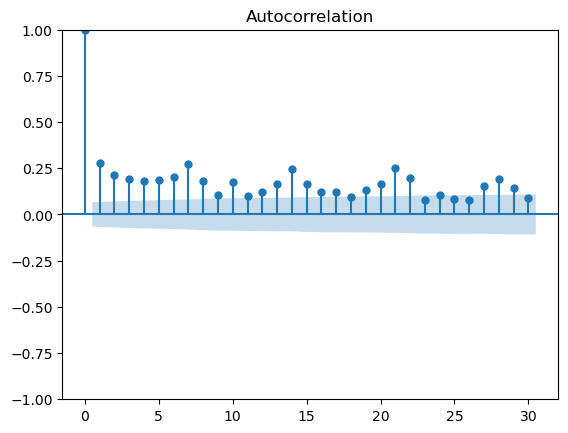

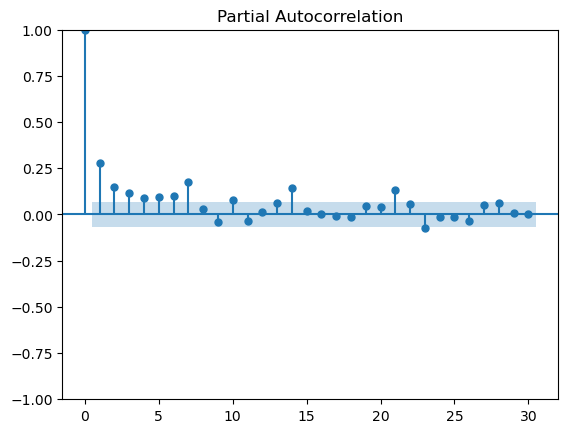

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df3)
plt.show()
plot_pacf(df3)
plt.show()

In [8]:
df=df3
df=df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df = df.query('"2019-01-01 00:00:00" <= Date < "2021-06-06 00:00:00"')
df=df.set_index('Date')
df.head()

,Incidents
Date,
2019-01-01,18.00
2019-01-02,20.00
2019-01-03,28.00
2019-01-04,27.00
2019-01-05,34.00


In [9]:
df=df.reset_index()
# Format Date column as a datetime object
df['Date'] = pd.to_datetime(df['Date'])
# Make a column for the date of the start of the week
df['Week_Start'] = df['Date'].dt.to_period('W').apply(lambda x: x.start_time)

# Make a column with the date for the Week End
df['Week_End'] = df['Week_Start'] + timedelta(days=6)
df['Week_Number'] = df['Date'].dt.week
df.head()

,Date,Incidents,Week_Start,Week_End,Week_Number
0,2019-01-01,18.00,2018-12-31,2019-01-06,1
1,2019-01-02,20.00,2018-12-31,2019-01-06,1
2,2019-01-03,28.00,2018-12-31,2019-01-06,1
3,2019-01-04,27.00,2018-12-31,2019-01-06,1
4,2019-01-05,34.00,2018-12-31,2019-01-06,1


In [10]:
Alldata = df.groupby(['Week_Number','Week_End'])['Incidents'].sum().reset_index()
Alldata.rename(columns={'Week_End':'Date','Incidents':'Incidents'}, inplace=True)
Alldata.head()

,Week_Number,Date,Incidents
0,1,2019-01-06,152.00
1,1,2020-01-05,253.00
2,1,2021-01-10,324.00
3,2,2019-01-13,318.00
4,2,2020-01-12,358.00


In [11]:
df = Alldata.sort_values(by='Date',ascending=True).reset_index(drop=True)
df.rename(columns={'Week_Number':'Week'}, inplace=True)
df.head()

,Week,Date,Incidents
0,1,2019-01-06,152.00
1,2,2019-01-13,318.00
2,3,2019-01-20,158.00
3,4,2019-01-27,207.00
4,5,2019-02-03,245.00


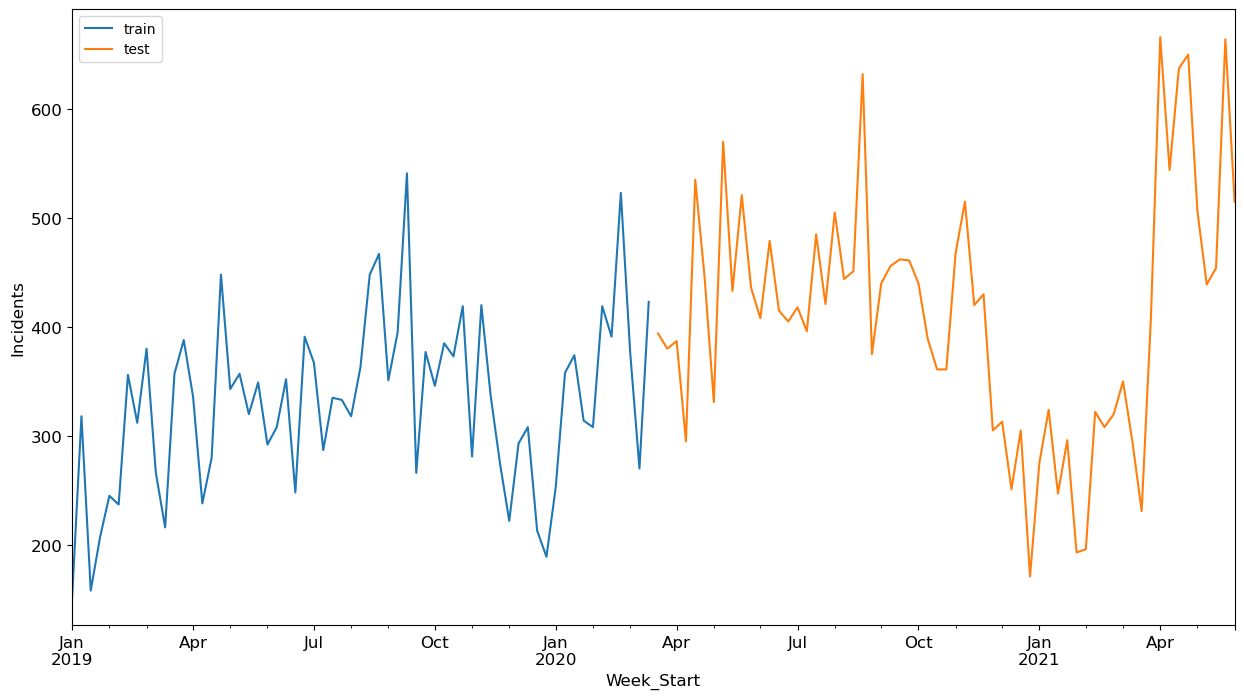

In [12]:
train_start_dt = '2019-01-01 00:00:00'
test_start_dt = '2020-03-19 00:00:00'  
Alldata = df.query('"2019-01-01 00:00:00" < Date < "2021-06-05 00:00:00"')
Alldata=Alldata.set_index('Date')
Alldata[(Alldata.index < test_start_dt) & (Alldata.index >= train_start_dt)][['Incidents']].rename(columns={'Incidents':'train'}) \
    .join(Alldata[test_start_dt:][['Incidents']].rename(columns={'Incidents':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('Week_Start', fontsize=12)
plt.ylabel('Incidents', fontsize=12)
os.chdir('C:\\Users\\omkarp\\Desktop\\')
plt.show()

In [13]:
train = Alldata.copy()[(Alldata.index >= train_start_dt) & (Alldata.index < test_start_dt)][['Incidents']]
test = Alldata.copy()[Alldata.index >= test_start_dt][['Incidents']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (63, 1)
Test data shape:  (63, 1)


In [14]:
scaler = MinMaxScaler()
train['Incidents'] = scaler.fit_transform(train)
train.head()

,Incidents
Date,
2019-01-06,0.00
2019-01-13,0.43
2019-01-20,0.02
2019-01-27,0.14
2019-02-03,0.24


,Incidents
Date,
2020-03-22,0.62
2020-03-29,0.59
2020-04-05,0.60
2020-04-12,0.37
2020-04-19,0.98


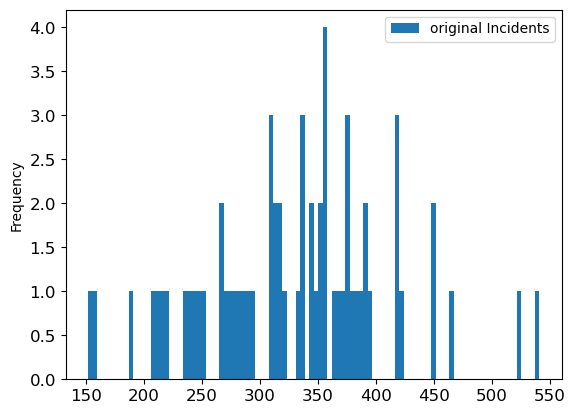

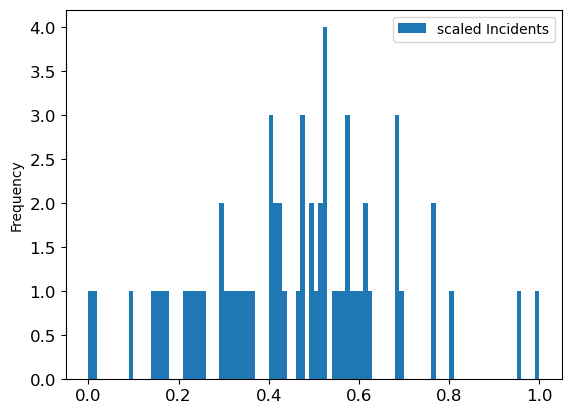

In [15]:
Alldata[(Alldata.index >= train_start_dt) & (Alldata.index < test_start_dt)][['Incidents']].rename(columns={'Incidents':'original Incidents'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'Incidents':'scaled Incidents'}).plot.hist(bins=100, fontsize=12)
test['Incidents'] = scaler.transform(test)
test.head()

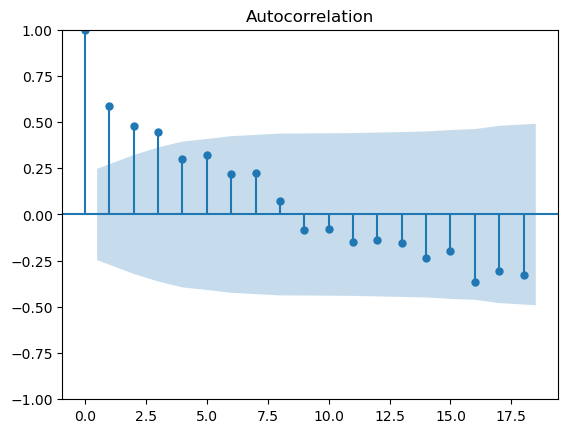

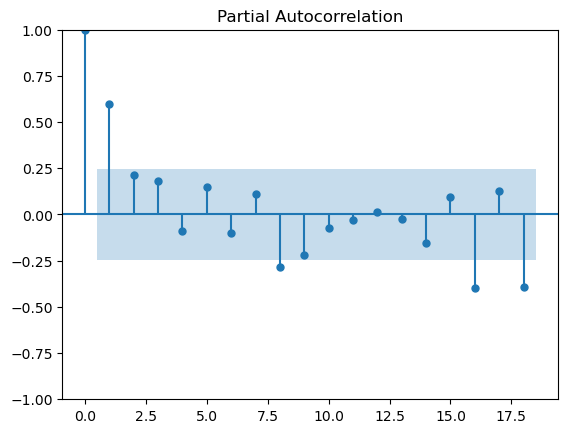

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(test)
plt.show()
plot_pacf(test)
plt.show()

In [17]:
Alldata.drop(columns={'Week'}, inplace=True)
Alldata.head()

,Incidents
Date,
2019-01-06,152.00
2019-01-13,318.00
2019-01-20,158.00
2019-01-27,207.00
2019-02-03,245.00


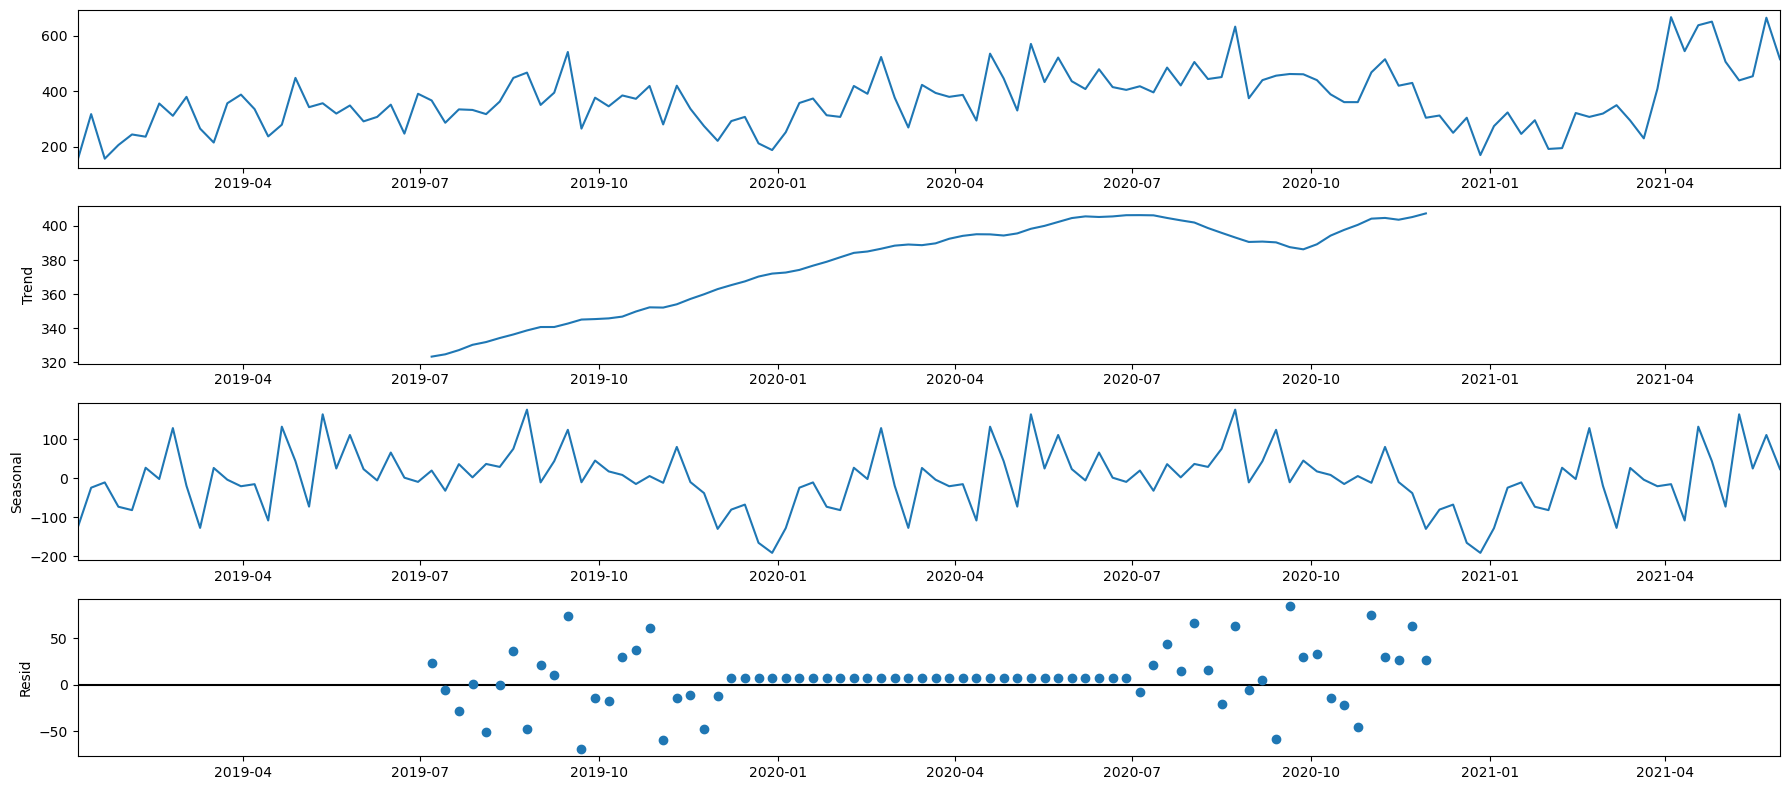

In [18]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(Alldata)
fig = decomposition.plot()
plt.show()

In [19]:
# Specify the number of steps to forecast ahead
HORIZON = 4
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 6)

model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         Incidents   No. Observations:                   63
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 6)   Log Likelihood                  -0.799
Date:                           Sun, 02 Apr 2023   AIC                             13.597
Time:                                   14:48:49   BIC                             25.749
Sample:                               01-06-2019   HQIC                            18.309
                                    - 03-15-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7138      0.143     -4.994      0.000      -0.994      -0.434
ar.L2         -0.6105      0.184     -3.314

In [20]:
test_shifted = test.copy()
test_shifted.head()

,Incidents
Date,
2020-03-22,0.62
2020-03-29,0.59
2020-04-05,0.60
2020-04-12,0.37
2020-04-19,0.98


In [21]:
for t in range(1, HORIZON): test_shifted['Incidents+'+str(t)] = test_shifted['Incidents'].shift(-t, freq='W')
test_shifted = test_shifted.dropna(how='any')
test_shifted.head()

,Incidents,Incidents+1,Incidents+2,Incidents+3
Date,,,,
2020-03-22,0.62,0.59,0.60,0.37
2020-03-29,0.59,0.60,0.37,0.98
2020-04-05,0.60,0.37,0.98,0.76
2020-04-12,0.37,0.98,0.76,0.46
2020-04-19,0.98,0.76,0.46,1.07


In [22]:
test_shifted=test_shifted.fillna(0.01)
test_shifted.tail()

,Incidents,Incidents+1,Incidents+2,Incidents+3
Date,,,,
2021-04-11,1.01,1.25,1.28,0.91
2021-04-18,1.25,1.28,0.91,0.74
2021-04-25,1.28,0.91,0.74,0.78
2021-05-02,0.91,0.74,0.78,1.32
2021-05-09,0.74,0.78,1.32,0.93


In [23]:
%%time
training_window = 720 # dedicate 30 days (720 hours) for training

train_ts = train['Incidents']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

# let's user simpler model for demonstration
order = (2, 1, 0)
seasonal_order = (1, 1, 0, 6)

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2020-03-22 00:00:00
1 : predicted = [0.61 0.57 1.01 0.77] expected = [0.622107969151671, 0.5861182519280205, 0.6041131105398457, 0.3676092544987146]
2020-03-29 00:00:00
2 : predicted = [0.56 1.   0.78 0.53] expected = [0.5861182519280205, 0.6041131105398457, 0.3676092544987146, 0.9845758354755784]
2020-04-05 00:00:00
3 : predicted = [1.01 0.79 0.54 0.78] expected = [0.6041131105398457, 0.3676092544987146, 0.9845758354755784, 0.7557840616966581]
2020-04-12 00:00:00
4 : predicted = [0.59 0.38 0.52 0.64] expected = [0.3676092544987146, 0.9845758354755784, 0.7557840616966581, 0.4601542416452442]
2020-04-19 00:00:00
5 : predicted = [0.26 0.44 0.49 0.47] expected = [0.9845758354755784, 0.7557840616966581, 0.4601542416452442, 1.074550128534704]
2020-04-26 00:00:00
6 : predicted = [0.77 0.74 0.92 1.01] expected = [0.7557840616966581, 0.4601542416452442, 1.074550128534704, 0.7223650385604113]
2020-05-03 00:00:00
7 : predicted = [0.72 0.92 1.   0.64] expected = [0.4601542416452442, 1.07455012853

2021-05-02 00:00:00
59 : predicted = [1.01 1.45 1.79 1.61] expected = [0.910025706940874, 0.7377892030848329, 0.7763496143958869, 1.3161953727506424]
2021-05-09 00:00:00
60 : predicted = [1.41 1.73 1.55 1.73] expected = [0.7377892030848329, 0.7763496143958869, 1.3161953727506424, 0.9331619537275063]
CPU times: total: 2.77 s
Wall time: 3.19 s


In [24]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2020-03-22,t+1,389.76,394.00
1,2020-03-29,t+1,370.98,380.00
2,2020-04-05,t+1,545.62,387.00
3,2020-04-12,t+1,379.77,295.00
4,2020-04-19,t+1,254.08,535.00


In [25]:
if(HORIZON > 1):
    eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
    print(eval_df.groupby('h')['APE'].mean())

h
t+1   0.22
t+2   0.26
t+3   0.28
t+4   0.30
Name: APE, dtype: float64


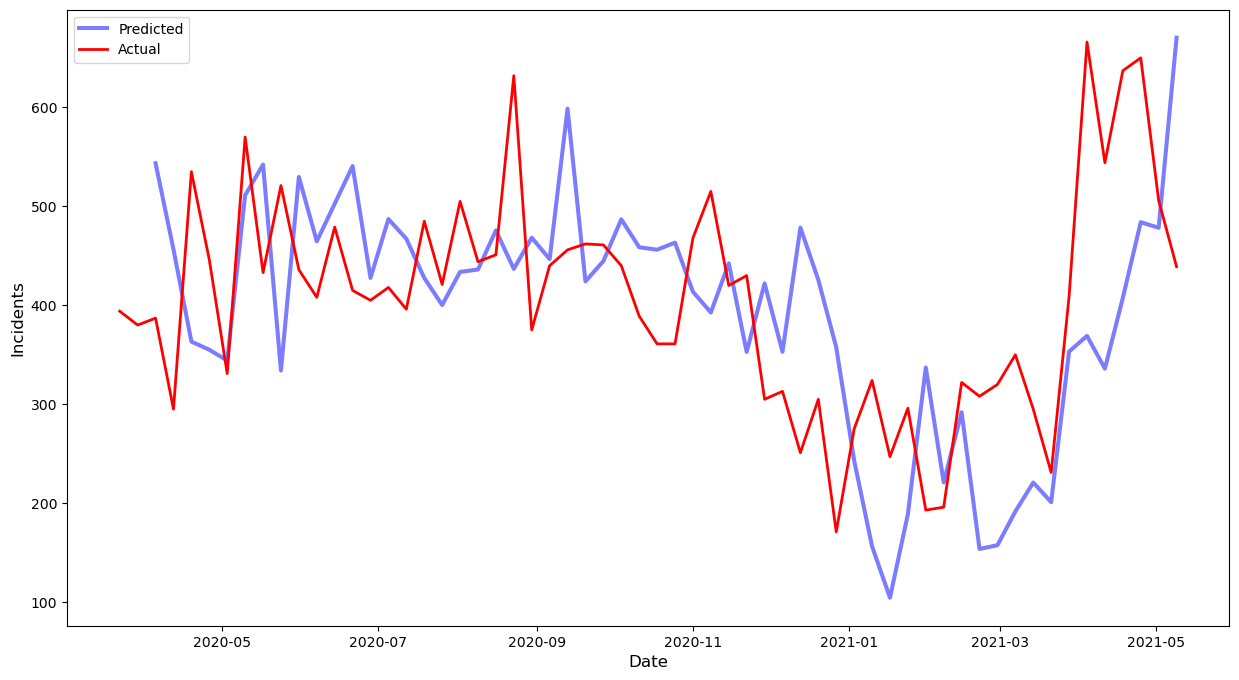

In [27]:
if(HORIZON == 1):
    ## Plotting single step forecast
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

else:
    ## Plotting multi step forecast
    plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
    for t in range(3, HORIZON):
        plot_df['t+'+str(t)] = eval_df[(eval_df.h=='t+'+str(t))]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    
    ax = fig.add_subplot(111)
    for t in range(3, HORIZON):
        x = plot_df['timestamp'][(t-1):]
        y = plot_df['t+'+str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4*math.pow(.9,t), alpha=math.pow(0.8,t))
    ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=2.0)
    
    
plt.xlabel('Date', fontsize=12)
plt.ylabel('Incidents', fontsize=12)
plt.legend(["Predicted", "Actual"], loc=0)
plt.show()

In [28]:
eval_df.tail()

,timestamp,h,prediction,actual,APE
235,2021-04-11,t+4,420.23,506.00,0.17
236,2021-04-18,t+4,633.36,439.00,0.44
237,2021-04-25,t+4,791.37,454.00,0.74
238,2021-05-02,t+4,780.22,664.00,0.18
239,2021-05-09,t+4,825.26,515.00,0.60


# Plotting predictions with confidence intervals

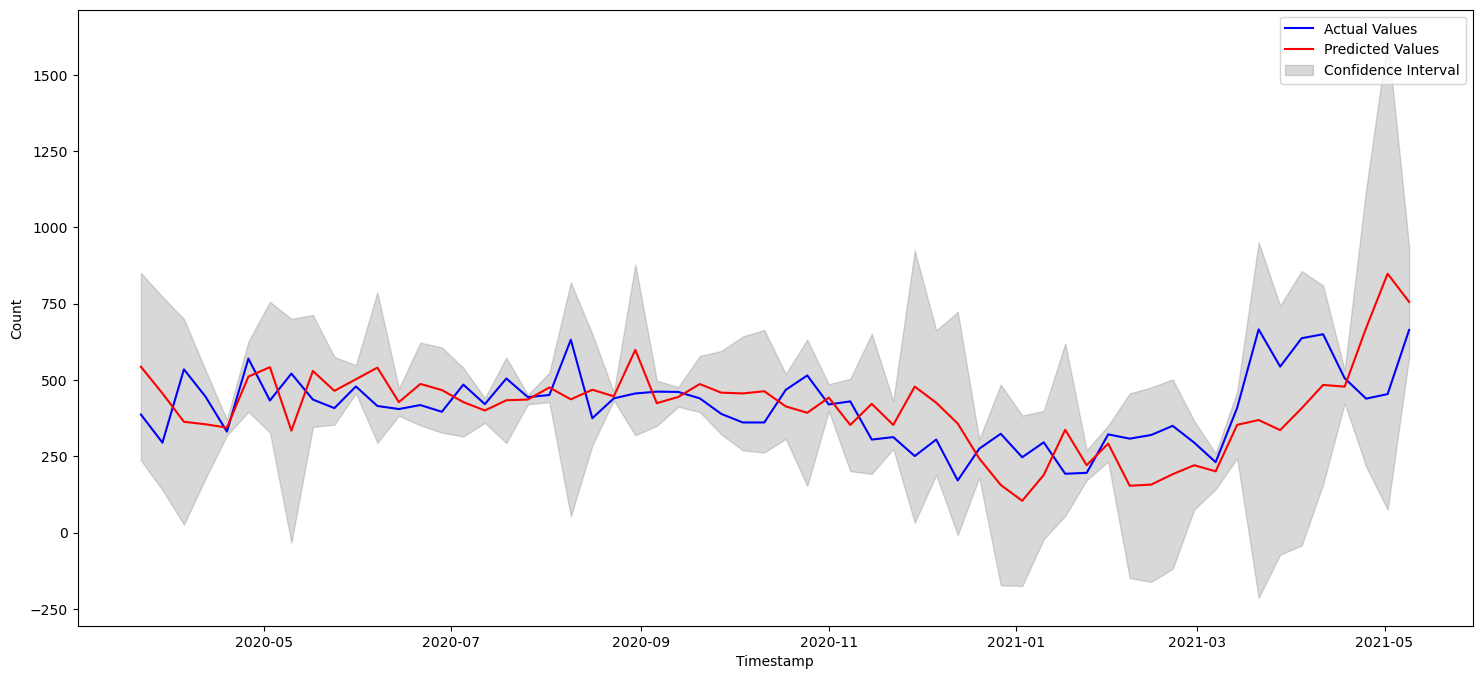

In [32]:
df = eval_df[eval_df['h'] == 't+3']
# Create a figure and axis for the plot
fig, ax = plt.subplots()
# Plot the actual values as a blue line
ax.plot(df['timestamp'], df['actual'], color='blue', label='Actual Values')

# Plot the predicted values as a red line
ax.plot(df['timestamp'], df['prediction'], color='red', label='Predicted Values')

# Calculate and plot the confidence interval as a shaded region
y_upper = df['prediction'] + 1.96 * df['APE'] * df['actual']
y_lower = df['prediction'] - 1.96 * df['APE'] * df['actual']
ax.fill_between(df['timestamp'], y_lower, y_upper, color='gray', alpha=0.3, label='Confidence Interval')

# Add a legend and axis labels
ax.legend()
ax.set_xlabel('Timestamp')
ax.set_ylabel('Count')

# Display the plot
plt.show()

In [30]:
eval_df['h'].unique()

array(['t+1', 't+2', 't+3', 't+4'], dtype=object)

# Prediction metrics

In [33]:
from sklearn.metrics import mean_absolute_percentage_error
Y_actual = eval_df['actual']
Y_Predicted = eval_df['prediction']
mean_absolute_percentage_error(Y_actual, Y_Predicted)

0.2643150835674526

In [34]:
# Root Mean Squared Error (RMSE)
y_actual = eval_df['actual']
y_predicted = eval_df['prediction']
RMSE = math.sqrt(np.square(np.subtract(y_actual,y_predicted)).mean())
print("Root Mean Square Error:", RMSE)

Root Mean Square Error: 127.77464830329679


In [35]:
#Symmetric Mean Absolute Percentage Error (sMAPE)
A = eval_df['actual']
F = eval_df['prediction']
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

print(smape(A, F))

26.297972313663283
